In [1]:
!pip install PyMuPDF
!pip install pdfminer.six
import fitz  # PyMuPDF for PDF processing
import re
import os
import csv
import pandas as pd
from pdfminer.high_level import extract_text

# Load the PDF file
def load_pdf(file_path):
    try:
        document = fitz.open(file_path)
        return document
    except Exception:
        return None

# Extract all text from the PDF using MuPDF or fallback to PDFMiner if MuPDF fails
def extract_text_from_pdf(document, file_path):
    if document:
        text = ""
        try:
            for page_num in range(len(document)):
                page = document.load_page(page_num)
                text += f"PAGE {page_num + 1}\n" + page.get_text()
            return text
        except Exception:
            pass
    # Fallback to using PDFMiner
    try:
        return extract_text(file_path)
    except Exception:
        return ""

# Function to check if a page contains references
def is_reference_page(page_text):
    reference_keywords = ["references", "bibliography", "references and notes","CrossRef"]
    for keyword in reference_keywords:
        if re.search(r'\b' + keyword + r'\b', page_text, re.IGNORECASE):
            return True
    return False

# Simplified search function using a list of search terms
def search_sentences_with_context(text, search_list):
    """
    Search for sentences in the text that contain any of the terms in the search list,
    and extract the sentence along with 10 preceding and 10 following sentences.
    """
    result = []
    # Split the text by pages
    pages = text.split("PAGE ")
    for page in pages[1:]:  # Skip the first split since it will be empty
        page_number, page_text = page.split("\n", 1)

        # Skip the page if it is a reference page
        if is_reference_page(page_text):
            continue

        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', page_text)
        for i, sentence in enumerate(sentences):
            for term in search_list:
                pattern = re.compile(rf'\b{re.escape(term)}\b', re.IGNORECASE)
                if pattern.search(sentence):
                    # Extract context: 10 sentences before and after the matched sentence
                    context = " ".join(sentences[max(0, i - 10):min(len(sentences), i + 11)])

                    # Find the line number
                    line_number = page_text[:page_text.find(sentence)].count('\n') + 1
                    result.append((term, sentence, context, int(page_number), line_number))
    return result

# Process multiple PDF documents
def process_pdfs(file_paths, search_list):
    all_results = []
    for file_path in file_paths:
        document = load_pdf(file_path)
        text = extract_text_from_pdf(document, file_path) if document else extract_text(file_path)
        results = search_sentences_with_context(text, search_list)
        search_items = "; ".join(search_list)
        file_name = os.path.basename(file_path)

        if results:
            # Extract the title from the first page or first few lines of the text
            title = text.splitlines()[0] if text.splitlines() else "Unknown Title"
            for item in results:
                all_results.append((file_name, title, item[1], f"found by {item[0]}", item[3], item[4], item[2]))

    return all_results

# Save results to CSV file
def save_results_to_csv(results, csv_file):
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, quoting=csv.QUOTE_ALL, escapechar='\\')
        writer.writerow(["File", "Title", "Sentence", "Found In", "Page", "Line", "Context"])
        for result in results:
            writer.writerow([str(field) for field in result])

# Function to find licenses in text and return the matched license
def find_license_in_text(text, license_list):
    for license in license_list:
        if license in text:
            return license
    return None

# Function to find LLM applications in text and return the matched application
def find_application_in_text(text, application_list):
    for application in application_list:
        if application in text:
            return application
    return None

# Process PDFs and save results to a CSV file
def main():
    current_dir = os.getcwd()
    file_paths = [os.path.join(current_dir, f) for f in os.listdir(current_dir) if f.lower().endswith('.pdf')]

    # LLM list to search for
    llm_list = [
        'GPT-3', 'GPT-4', 'BERT', 'RoBERTa', 'XLNet', 'T5', 'ALBERT',
        'DistilBERT', 'ERNIE', 'ELECTRA', 'Megatron', 'Turing-NLG',
        'Transformer-XL', 'OpenAI Codex', 'BART', 'Pegasus', 'Reformer',
        'CTRL', 'BigGAN', 'DeBERTa', 'BlenderBot', 'GShard', 'Switch-Transformer',
        'PanGu-α', 'MT-NLG', 'GLaM', 'WuDao', 'Jurassic-1', 'LaMDA', 'OPT',
        'LLaMA', 'ChatGPT',
        'GPT-2', 'WebGPT', 'Ernie 3.0 Titan', 'Gopher', 'FLAN', 'Yuan 1.0',
        'T0', 'HyperCLOVA', 'NAVER', 'CPM-2', 'PLUG', 'CodeGen', 'Chinchilla',
        'AlphaCode', 'GPT-NeoX-20B', 'Tk-Instruct', 'Cohere', 'UL2',
        'PaLM', 'YaLM', 'CodeGeeX', 'GLM', 'AlexaTM', 'WeLM', 'RWKV',
        'Sparrow', 'Flan-T5', 'Flan-PaLM', 'Luminous', 'NLLB', 'BLOOM',
        'mT0', 'BLOOMZ', 'Galatica', 'OPT-IML', 'Gemini', 'Ernie 4.0',
        'Grok-1', 'Aquila2', 'FLM', 'QWEN', 'Baichuan2', 'LLaMA2',
        'Falcon 180B', 'CodeGen2', 'PaLM2', 'Baichuan', 'MPT',
        'InternLM', 'LLaMA 65B', 'Bard', 'PanGu-sum', 'Vicuna',
        'Pythia', 'Sora', 'Gemini 1.5', 'Claude 3 Opus',
        'Llama3', 'phi-3',
        'Mistral', 'Claude', 'Claude 2', 'Claude 3', 'Claude Next',
        'Anthropic LLM', 'ChatGPT-4 Turbo', 'Megatron-Turing NLG',
        'GPT-J', 'GPT-Neo', 'Bloom', 'Jurrasic-2', 'BLOOMZ',
        'Alpaca', 'StableLM', 'Phoenix', 'XGen', 'Grok-2',
        'Gemini 1', 'Gemini 2', 'Gemini 3', 'Aquila', 'Aquila-Chat',
        'Meta AI BlenderBot', 'Sirius', 'Prometheus', 'Orca',
        'Falcon', 'BLOOM 176B', 'Turing-NLG 17B', 'Megatron-LM',
        'T5-11B', 'BigScience', 'Coqui TTS', 'Neuralink LM',
        'Mosaic GPT', 'Mosaic BERT', 'Turing', 'Unity-3B', 'Hera'
    ]

    # Process PDFs for LLM list and save results to a CSV file
    results_llms = process_pdfs(file_paths, llm_list)
    save_results_to_csv(results_llms, 'search_results_llms.csv')

    # License list to search for
    search_list_licenses = [
        'AFL-3.0', 'Academic Free License v3.0', 'Apache-2.0',
        'Apache license 2.0', 'Artistic-2.0', 'Artistic license 2.0',
        'BSL-1.0', 'Boost Software License 1.0', 'BSD-2-Clause',
        "BSD 2-clause 'Simplified' license", 'BSD-3-Clause',
        "BSD 3-clause 'New' or 'Revised' license", 'BSD-3-Clause-Clear',
        'BSD 3-clause Clear license', 'BSD-4-Clause',
        "BSD 4-clause 'Original' or 'Old' license", '0BSD',
        'BSD Zero-Clause license', 'CC0-1.0', 'Creative Commons Zero v1.0 Universal',
        'CC-BY-4.0', 'Creative Commons Attribution 4.0',
        'CC-BY-SA-4.0', 'Creative Commons Attribution ShareAlike 4.0',
        'ECL-2.0','Educational Community License v2.0', 'EPL-1.0',
        'Eclipse Public License 1.0',
        'EPL-2.0', 'Eclipse Public License 2.0', 'EUPL-1.1',
        'European Union Public License 1.1', 'AGPL-3.0',
        'GNU Affero General Public License v3.0', 'GPL',
        'GNU General Public License family', 'GPL-2.0',
        'GNU General Public License v2.0', 'GPL-3.0', 'GNU General Public License v3.0',
        'LGPL', 'GNU Lesser General Public License family', 'LGPL-2.1',
        'GNU Lesser General Public License v2.1', 'LGPL-3.0',
        'GNU Lesser General Public License v3.0',  'ISC', 'LPPL-1.3c',
        'LaTeX Project Public License v1.3c', 'MS-PL', 'Microsoft Public License',
        'MIT', 'MPL-2.0', 'Mozilla Public License 2.0', 'OSL-3.0',
        'Open Software License 3.0', 'PostgreSQL', 'PostgreSQL License',
        'OFL-1.1', 'SIL Open Font License 1.1', 'NCSA',
        'University of Illinois/NCSA Open Source License',
        'Unlicense', 'The Unlicense', 'Zlib', 'zLib License', 'license', 'licence'
    ]

    # Create a DataFrame to store the results
    df = pd.read_csv('search_results_llms.csv')
    filtered_df = pd.DataFrame(columns=['File', 'Title', 'Sentence', 'Context', 'Page', 'Line', 'Found License'])

    # Check each row for license mentions
    for index, row in df.iterrows():
        found_license_in_context = find_license_in_text(row['Context'], search_list_licenses)
        if found_license_in_context:
            new_row = row.copy()
            new_row['Found License'] = found_license_in_context
            new_row['Context'] = " ".join(new_row['Context'].split())
            filtered_df = pd.concat([filtered_df, pd.DataFrame([new_row])])

    # Remove duplicates and save to CSV
    filtered_df = filtered_df.drop_duplicates(subset=['Context'])
    filtered_df.to_csv('filtered_license_context_only.csv', index=False)
    print("Filtered data has been saved to 'filtered_license_context_only.csv'")

    # LLM applications to search for
    llm_applications = [
        'Text Generation and Auto-Writing',
        'Machine Translation',
        'Question Answering Systems',
        'Text Summarization',
        'Sentiment Analysis',
        'Conversational Agents',
        'Information Retrieval',
        'Content Creation Assistance',
        'Code Generation and Programming Assistance',
        'Personalized Recommendations',
        'Grammar Checking and Text Proofreading',
        'Knowledge Graph Construction',
        'Text Classification',
        'Fine-Tuning for Domain-Specific Tasks',
        'Speech Recognition and Synthesis',
        'Virtual Assistants',
        'Automatic Alignment and Synchronization',
        'Education and Learning Support',
        'Data Augmentation',
        'Knowledge Exploration and Inquiry'
    ]

    # Create a DataFrame to store the results
    filtered_df = pd.DataFrame(columns=['File', 'Title', 'Sentence', 'Context', 'Page', 'Line', 'Found Application'])

    # Check each row for LLM application mentions
    for index, row in df.iterrows():
        found_application_in_context = find_application_in_text(row['Context'], llm_applications)
        if found_application_in_context:
            new_row = row.copy()
            new_row['Found Application'] = found_application_in_context
            new_row['Context'] = " ".join(new_row['Context'].split())
            filtered_df = pd.concat([filtered_df, pd.DataFrame([new_row])])

    # Remove duplicates and save to CSV
    filtered_df = filtered_df.drop_duplicates(subset=['Context'])
    filtered_df.to_csv('filtered_llm_applications_context_only.csv', index=False)
    print("Filtered data has been saved to 'filtered_llm_applications_context_only.csv'")

main()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.3 MB/s eta 0:00:00
Filtered data has been saved to 'filtered_license_context_only.csv'
Filtered data has been saved to 'filtered_llm_applications_context_only.csv'


In [4]:
import pandas as pd
import re

# Define the list of model names and their applications/licenses
llm_list = [
    'GPT-3', 'GPT-4', 'BERT', 'RoBERTa', 'XLNet', 'T5', 'ALBERT',
    'DistilBERT', 'ERNIE', 'ELECTRA', 'Megatron', 'Turing-NLG',
    'Transformer-XL', 'OpenAI Codex', 'BART', 'Pegasus', 'Reformer',
    'CTRL', 'BigGAN', 'DeBERTa', 'BlenderBot', 'GShard', 'Switch-Transformer',
    'PanGu-α', 'MT-NLG', 'GLaM', 'WuDao', 'Jurassic-1', 'LaMDA', 'OPT',
    'LLaMA', 'ChatGPT', 'GPT-2', 'WebGPT', 'Ernie 3.0 Titan', 'Gopher', 'FLAN',
    'Yuan 1.0', 'T0', 'HyperCLOVANAVER', 'CPM-2', 'PLUG', 'CodeGen', 'Chinchilla',
    'AlphaCode', 'GPT-NeoX-20B', 'Tk-Instruct', 'Cohere', 'UL2', 'PaLM', 'YaLM',
    'CodeGeeX', 'GLM', 'AlexaTM', 'WeLM', 'RWKV', 'Sparrow', 'Flan-T5', 'Flan-PaLM',
    'Luminous', 'NLLB', 'BLOOM', 'mT0', 'BLOOMZ', 'Galatica', 'OPT-IML', 'Gemini',
    'Ernie 4.0', 'Grok-1', 'Aquila2', 'FLM', 'QWEN', 'Baichuan2', 'LLaMA2',
    'Falcon 180B', 'CodeGen2', 'PaLM2', 'Baichuan', 'MPT', 'InternLM', 'LLaMA 65B',
    'Bard', 'PanGu-sum', 'Vicuna', 'Pythia', 'Sora', 'Gemini 1.5', 'Claude 3 Opus',
    'Llama3', 'phi-3', 'Mistral', 'Claude', 'Claude 2', 'Claude 3', 'Claude Next',
    'Anthropic LLM', 'ChatGPT-4 Turbo', 'Megatron-Turing NLG', 'GPT-J', 'GPT-Neo',
    'Bloom', 'Jurrasic-2', 'BLOOMZ', 'Alpaca', 'StableLM', 'Phoenix', 'XGen',
    'Grok-2', 'Gemini 1', 'Gemini 2', 'Gemini 3', 'Aquila', 'Aquila-Chat',
    'Meta AI BlenderBot', 'Sirius', 'Prometheus', 'Orca', 'Falcon', 'BLOOM 176B',
    'Turing-NLG 17B', 'Megatron-LM', 'T5-11B', 'BigScience', 'Coqui TTS',
    'Neuralink LM', 'Mosaic GPT', 'Mosaic BERT', 'Turing', 'Unity-3B', 'Hera'
]

# Define list of possible LLM applications
llm_applications = [
    'Text Generation and Auto-Writing', 'Machine Translation',
    'Question Answering Systems', 'Text Summarization', 'Sentiment Analysis',
    'Conversational Agents', 'Information Retrieval', 'Content Creation Assistance',
    'Code Generation and Programming Assistance', 'Personalized Recommendations',
    'Grammar Checking and Text Proofreading', 'Knowledge Graph Construction',
    'Text Classification', 'Fine-Tuning for Domain-Specific Tasks',
    'Speech Recognition and Synthesis', 'Virtual Assistants',
    'Automatic Alignment and Synchronization', 'Education and Learning Support',
    'Data Augmentation', 'Knowledge Exploration and Inquiry'
]

# Define list of possible licenses
search_list_licenses = [
    'AFL-3.0', 'Academic Free License v3.0', 'Apache-2.0', 'Apache license 2.0',
    'Artistic-2.0', 'Artistic license 2.0', 'BSL-1.0', 'Boost Software License 1.0',
    'BSD-2-Clause', "BSD 2-clause 'Simplified' license", 'BSD-3-Clause',
    "BSD 3-clause 'New' or 'Revised' license", 'BSD-3-Clause-Clear',
    'BSD 3-clause Clear license', 'BSD-4-Clause', "BSD 4-clause 'Original' or 'Old' license",
    '0BSD', 'BSD Zero-Clause license', 'CC0-1.0', 'Creative Commons Zero v1.0 Universal',
    'CC-BY-4.0', 'Creative Commons Attribution 4.0', 'Creative Commons Attribution International 4.0',
    'CC-BY-SA-4.0', 'Creative Commons Attribution ShareAlike 4.0', 'ECL-2.0',
    'Educational Community License v2.0', 'EPL-1.0', 'Eclipse Public License 1.0',
    'EPL-2.0', 'Eclipse Public License 2.0', 'EUPL-1.1', 'European Union Public License 1.1',
    'AGPL-3.0', 'GNU Affero General Public License v3.0', 'GPL', 'GNU General Public License family',
    'GPL-2.0', 'GNU General Public License v2.0', 'GPL-3.0', 'GNU General Public License v3.0',
    'LGPL', 'GNU Lesser General Public License family', 'LGPL-2.1', 'GNU Lesser General Public License v2.1',
    'LGPL-3.0', 'GNU Lesser General Public License v3.0', 'ISC', 'LPPL-1.3c',
    'LaTeX Project Public License v1.3c', 'MS-PL', 'Microsoft Public License',
    'MIT', 'MPL-2.0', 'Mozilla Public License 2.0', 'OSL-3.0',
    'Open Software License 3.0', 'PostgreSQL', 'PostgreSQL License',
    'OFL-1.1', 'SIL Open Font License 1.1', 'NCSA', 'University of Illinois/NCSA Open Source License',
    'Unlicense', 'The Unlicense', 'Zlib', 'zLib License', 'license', 'licence'
]

# Function to label tokens in a context with BIO tags for models, applications, and licenses
def label_tokens(context, llm_list, application_list, license_list):
    tokens = context.split()
    labels = ["O"] * len(tokens)

    # Label models
    for model in llm_list:
        match = re.search(re.escape(model), context)
        if match:
            start_idx = len(context[:match.start()].split())
            end_idx = len(context[:match.end()].split()) - 1
            labels[start_idx] = "B-MODEL"
            for i in range(start_idx + 1, end_idx + 1):
                labels[i] = "I-MODEL"

    # Label applications
    for application in application_list:
        match = re.search(re.escape(application), context)
        if match:
            start_idx = len(context[:match.start()].split())
            end_idx = len(context[:match.end()].split()) - 1
            labels[start_idx] = "B-APPLICATION"
            for i in range(start_idx + 1, end_idx + 1):
                labels[i] = "I-APPLICATION"

    # Label licenses
    for license in license_list:
        match = re.search(re.escape(license), context)
        if match:
            start_idx = len(context[:match.start()].split())
            end_idx = len(context[:match.end()].split()) - 1
            labels[start_idx] = "B-LICENSE"
            for i in range(start_idx + 1, end_idx + 1):
                labels[i] = "I-LICENSE"

    return tokens, labels

# Load the CSV files
applications_file_path = '/content/sample_data/filtered_llm_applications_context_only.csv'  # Replace with your file path
licenses_file_path = '/content/sample_data/filtered_license_context_only.csv'  # Replace with your file path

# Process and label contexts in the applications file
df_applications = pd.read_csv(applications_file_path)
labeled_data_applications = []
for index, row in df_applications.iterrows():
    tokens, labels = label_tokens(row['Context'], llm_list, llm_applications, [])
    labeled_data_applications.append({"Context": row['Context'], "Tokens": tokens, "Labels": labels})

# Convert the labeled application data to a DataFrame and save it
labeled_df_applications = pd.DataFrame(labeled_data_applications)
labeled_df_applications.to_csv('labeled_contexts_with_bio_applications.csv', index=False)
print("Labeled data for applications has been saved to 'labeled_contexts_with_bio_applications.csv'")

# Process and label contexts in the licenses file
df_licenses = pd.read_csv(licenses_file_path)
labeled_data_licenses = []
for index, row in df_licenses.iterrows():
    tokens, labels = label_tokens(row['Context'], llm_list, [], search_list_licenses)
    labeled_data_licenses.append({"Context": row['Context'], "Tokens": tokens, "Labels": labels})

# Convert the labeled license data to a DataFrame and save it
labeled_df_licenses = pd.DataFrame(labeled_data_licenses)
labeled_df_licenses.to_csv('labeled_contexts_with_bio.csv', index=False)
print("Labeled data for licenses has been saved to 'labeled_contexts_with_bio.csv'")


Labeled data for applications has been saved to 'labeled_contexts_with_bio_applications.csv'
Labeled data for licenses has been saved to 'labeled_contexts_with_bio.csv'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.3 MB/s eta 0:00:00
ERNIE	ERNIE	PROPN	NNP	nsubj	[]
is	be	AUX	VBZ	ROOT	['ERNIE:nsubj', 'effective:acomp', '.:punct']
effective	effective	ADJ	JJ	acomp	['in:prep']
in	in	ADP	IN	prep	['Recognition:pobj']
Named	name	VERB	VBN	compound	[]
Entity	Entity	PROPN	NNP	compound	[]
Recognition	Recognition	PROPN	NNP	pobj	['Named:compound', 'Entity:compound', '(:punct', 'NER:appos', '):punct', ',:punct', 'in:prep']
(	(	PUNCT	-LRB-	punct	[]
NER	NER	PROPN	NNP	appos	[]
)	)	PUNCT	-RRB-	punct	[]
,	,	PUNCT	,	punct	[]
particularly	particularly	ADV	RB	advmod	[]
in	in	ADP	IN	prep	['particularly:advmod', 'text:pobj']
Chinese	chinese	ADJ	JJ	amod	[]
text	text	NOUN	NN	pobj	['Chinese:amod']
.	.	PUNCT	.	punct	[]


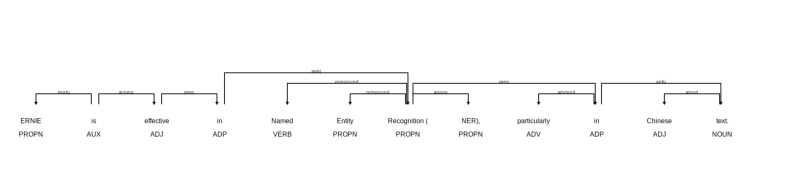

In [3]:
!pip install cairosvg
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import cairosvg

# Load the pre-trained spaCy model for English
nlp = spacy.load('en_core_web_sm')

# Process a sentence with the spaCy model
doc = nlp("ERNIE is effective in Named Entity Recognition (NER), particularly in Chinese text.")

# Output the dependency relations for each token in the sentence
for token in doc:
    print(token.text + '\t' + token.lemma_ + '\t' + token.pos_ + '\t' + token.tag_ + '\t' + token.dep_ + '\t' + str([child.text + ':' + child.dep_ for child in token.children]))

# Render the dependency parse tree using spaCy's displaCy visualizer and save it as an SVG
svg = displacy.render(doc, style='dep', jupyter=False, options={'compact': True})

# Convert the SVG data to PNG format using cairosvg
png_data = cairosvg.svg2png(bytestring=svg.encode('utf-8'))

# Load the PNG data into a PIL Image object
img = Image.open(BytesIO(png_data))

# Save the image as a PNG file
img.save("dependency_parse.png")

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes for a cleaner display
plt.show()


In [4]:
import pandas as pd
import spacy

# Load spaCy's language model
nlp = spacy.load('en_core_web_sm')

# Define the relationship extraction function
def extract_relationship(doc):
    subject = None
    obj = None
    relation = None
    is_passive = False

    # Check if the sentence is in passive voice
    for token in doc:
        if token.dep_ == "auxpass":
            is_passive = True

    for token in doc:
        if token.dep_ == "ROOT":
            # Extract the main verb along with any auxiliary verbs
            aux_verbs = " ".join([child.text for child in token.children if child.dep_ in ("aux", "auxpass")])
            relation = f"{aux_verbs} {token.text}".strip()

            if is_passive:
                # Handle passive voice
                for child in token.children:
                    if child.dep_ == "nsubjpass":
                        subject = " ".join([t.text for t in child.subtree])  # Extract passive subject
                    if child.dep_ == "prep":
                        if obj is None:
                            preposition = child.text
                            for pobj in child.children:
                                if pobj.dep_ == "pobj":
                                    obj = " ".join([t.text for t in pobj.subtree])
                            relation = f"{relation} {preposition}".strip()
            else:
                # Handle active voice
                for child in token.children:
                    if child.dep_ == "nsubj":
                        subject = " ".join([t.text for t in child.subtree])  # Extract active subject
                    if child.dep_ == "acomp":
                        # Handle adjectival complements and prepositional phrases
                        relation = f"{relation} {child.text}".strip()
                        for acomp_child in child.children:
                            if acomp_child.dep_ == "prep" and obj is None:
                                preposition = acomp_child.text
                                for pobj in acomp_child.children:
                                    if pobj.dep_ == "pobj":
                                        obj = " ".join([t.text for t in pobj.subtree])
                                relation = f"{relation} {preposition}".strip()
                    elif child.dep_ == "dobj" and obj is None:
                        obj = " ".join([t.text for t in child.subtree])  # Extract direct object
                    elif child.dep_ == "prep" and obj is None:
                        # Handle prepositional phrases in active voice
                        preposition = child.text
                        for pobj in child.children:
                            if pobj.dep_ == "pobj":
                                obj = " ".join([t.text for t in pobj.subtree])
                        relation = f"{relation} {preposition}".strip()

    if subject and obj and relation:
        # Remove the article 'the' from the object if present
        if obj.startswith("the "):
            obj = obj[4:]  # Remove "the "
        return (subject, relation, obj)
    else:
        return None

# Process sentences to extract relationships
def process_sentences(file_path, sentence_column):
    # Read the dataset
    data = pd.read_csv(file_path)

    relations = []
    for sentence in data[sentence_column]:
        doc = nlp(sentence)
        relationship = extract_relationship(doc)
        if relationship:
            relations.append(relationship)
        else:
            relations.append(('N/A', 'N/A', 'N/A'))  # If no relationship is found, mark as N/A

    # Create a DataFrame for the extracted relationships
    relations_df = pd.DataFrame(relations, columns=['Subject', 'Relation', 'Object'])

    return relations_df

# Define paths and columns for different datasets
llm_file_path = '/content/sample_data/llm_model_applications.csv'
license_file_path = '/content/sample_data/license_sentences.csv'

# Process the LLM dataset
llm_relations_df = process_sentences(llm_file_path, 'sentence')
llm_output_path = 'extracted_llm_relationships.csv'
llm_relations_df.to_csv(llm_output_path, index=False)

# Process the license dataset
license_relations_df = process_sentences(license_file_path, 'Sentence')
license_output_path = 'extracted_license_relationships.csv'
license_relations_df.to_csv(license_output_path, index=False)

# Clean the extracted relationships
def clean_extracted_data(file_path):
    # Load the extracted relationships dataset
    data = pd.read_csv(file_path)

    # Display original data for verification
    print("Original Data:")
    print(data.head())

    # Remove rows with N/A values
    data_cleaned = data.dropna()

    # Remove duplicate rows
    data_cleaned = data_cleaned.drop_duplicates()

    # Save the cleaned data
    cleaned_output_path = 'cleaned_' + file_path
    data_cleaned.to_csv(cleaned_output_path, index=False)

    # Display cleaned data for verification
    print("\nCleaned Data:")
    print(data_cleaned.head())

    # Return the path to the cleaned file
    return cleaned_output_path

# Clean both extracted datasets and save the cleaned versions
cleaned_llm_path = clean_extracted_data(llm_output_path)
cleaned_license_path = clean_extracted_data(license_output_path)

# Display output paths for easy access
print(f"Cleaned LLM relationships saved to: {cleaned_llm_path}")
print(f"Cleaned License relationships saved to: {cleaned_license_path}")


Original Data:
  Subject     Relation                 Object
0   GPT-3  is used for        Text Generation
1   GPT-3       powers  Conversational Agents
2     NaN          NaN                    NaN
3   GPT-4     enhances        Text Generation
4   GPT-4     improves     Question Answering

Cleaned Data:
  Subject     Relation                 Object
0   GPT-3  is used for        Text Generation
1   GPT-3       powers  Conversational Agents
3   GPT-4     enhances        Text Generation
4   GPT-4     improves     Question Answering
5   GPT-4   is used in       Creative Writing
Original Data:
   Subject              Relation                             Object
0      NaN                   NaN                                NaN
1    GPT-4     is licensed under  a proprietary agreement by OpenAI
2     BERT    was released under                 Apache License 2.0
3  RoBERTa    is available under                 Apache License 2.0
4    XLNet  is distributed under                 Apache License

In [6]:
!pip install pyvis
import networkx as nx
import pandas as pd
from pyvis.network import Network

# Read the first cleaned triples dataset
file_path1 = '/content/cleaned_extracted_llm_relationships.csv'
triples_df1 = pd.read_csv(file_path1)

# Read the second cleaned triples dataset
file_path2 = '/content/cleaned_extracted_license_relationships.csv'
triples_df2 = pd.read_csv(file_path2)

# Triple class to maintain compatibility and consistency across different datasets
class Triple:
    def __init__(self, arg1, predicate, arg2):
        self.arg1 = arg1
        self.predicate = predicate
        self.arg2 = arg2

# Create a list of Triple objects from the first DataFrame
triples1 = [Triple(row['Subject'], row['Relation'], row['Object']) for index, row in triples_df1.iterrows()]

# Create a list of Triple objects from the second DataFrame
triples2 = [Triple(row['Subject'], row['Relation'], row['Object']) for index, row in triples_df2.iterrows()]

# Combine both triples lists into a single list
combined_triples = triples1 + triples2

# Function to generate a combined graph from the list of triples
def to_combined_graph(triples):
    graph = nx.Graph()  # Create an undirected graph
    argument_dict = {}  # Dictionary to map entities to node IDs
    node_id = 1  # Start node ID from 1

    for triple in triples:
        # Reuse existing ID for subject if it already exists in the graph
        if triple.arg1 in argument_dict:
            arg1_id = argument_dict[triple.arg1]
        else:
            arg1_id = node_id
            argument_dict[triple.arg1] = arg1_id
            node_id += 1

        predicate_id = node_id
        arg2_id = node_id + 1

        # Add nodes and edges to the graph
        graph.add_node(arg1_id, label=triple.arg1, type='subject', color='lightblue')
        graph.add_node(predicate_id, label=triple.predicate, type='predicate', color='lightgreen')
        graph.add_node(arg2_id, label=triple.arg2, type='object', color='lightcoral')

        graph.add_edge(arg1_id, predicate_id)
        graph.add_edge(predicate_id, arg2_id)

        node_id += 2  # Increment the node ID by 2 for the next triple

    return graph, argument_dict

# Generate the combined graph and the entity-to-node ID mapping dictionary
combined_graph, argument_dict = to_combined_graph(combined_triples)

# DFS query function to find all related triples starting from a specific entity
def dfs_query(start_entity, graph, argument_dict):
    """
    Perform a DFS search starting from the given entity and return all related triples in the format:
    Subject Predicate Object.

    :param start_entity: The starting entity for the DFS search (e.g., 'Turing-NLG').
    :param graph: The networkx graph containing all triples.
    :param argument_dict: The dictionary mapping entities to their node IDs in the graph.
    :return: A list of strings in the format "Subject Predicate Object".
    """
    if start_entity not in argument_dict:
        print(f"Entity '{start_entity}' not found in the graph.")
        return []

    start_node = argument_dict[start_entity]
    results = []
    successors = nx.dfs_tree(graph, start_node)

    for node in successors:
        if graph.nodes[node]['type'] == 'subject':
            subject_node = node
            for predicate_node in graph.neighbors(subject_node):
                if graph.nodes[predicate_node]['type'] == 'predicate':
                    for object_node in graph.neighbors(predicate_node):
                        if graph.nodes[object_node]['type'] == 'object':
                            subject = graph.nodes[subject_node]['label']
                            predicate = graph.nodes[predicate_node]['label']
                            obj = graph.nodes[object_node]['label']
                            results.append(f"{subject}\t{predicate}\t{obj}")

    return results

# Function to visualize the graph using PyVis
def display_graph(graph, output_file='my_combined_graph.html'):
    net = Network(notebook=True)
    for node in graph.nodes(data=True):
        net.add_node(node[0], label=node[1]['label'], title=node[1]['label'], color=node[1]['color'])
    for edge in graph.edges():
        net.add_edge(edge[0], edge[1])
    net.show(output_file)

# Visualize the combined graph
display_graph(combined_graph)

# Example usage: Query for 'Turing - NLG'
results = dfs_query('Turing - NLG', combined_graph, argument_dict)
for result in results:
    print(result)


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
my_combined_graph.html
Turing - NLG	is applied in	Conversational Agents
Turing - NLG	supports	Creative Writing
Turing - NLG	is licensed under	a proprietary agreement with Microsoft
